torch.Size([1, 1, 612, 612])


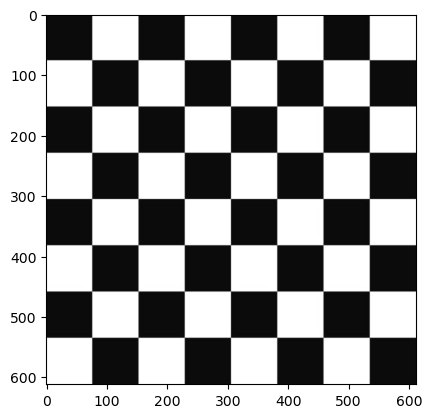

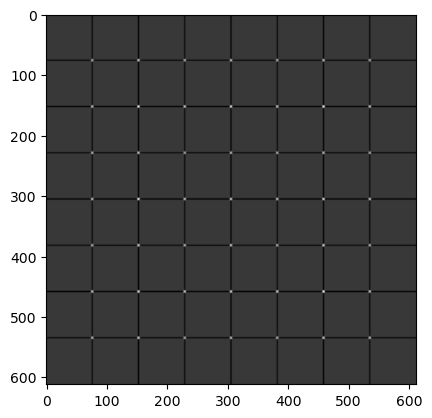

In [3]:
import torch
from torchvision import transforms
import kornia.feature as KF
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

filename = './data/chessboard.jpg'
tensor = transforms.ToTensor()(Image.open(filename).convert('L')).unsqueeze(0)
print(tensor.shape)

plt.imshow(tensor.squeeze(), cmap='gray')
plt.show()

harris = KF.responses.CornerHarris(0.05)
cornerness = harris(tensor)

plt.imshow(cornerness.squeeze(), cmap='gray')
plt.show()

## Example of the scale pyramid

- ScalePyramid(n_levels, init_sigma, min_size, double_image)
    - 피라미드 개수, 얼마나 스케일링 해줄지, 어느 정도까지 줄어들지

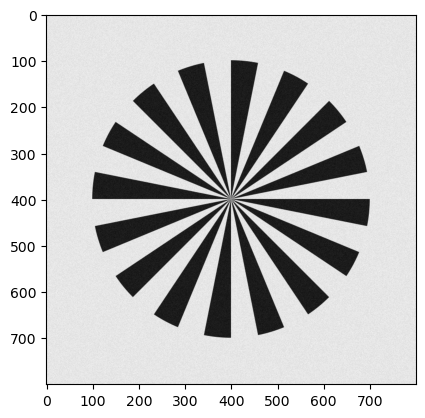

In [4]:
import kornia
import kornia.geometry as KG
from kornia import tensor_to_image as tti

# ScalePyramid create spyramid of blurred and downsamples images
SP = KG.ScalePyramid(3, 1.0, 10)

filename = './data/siemens.png'
img = Image.open(filename) # PIL
timg = kornia.utils.image_to_tensor(np.array(img), keepdim=False).float() / 255. / 255. # Tensor 변경
plt.imshow(kornia.utils.tensor_to_image(timg[0]), 'gray')

In [5]:
# Corner Detection
resp = KF.responses.CornerHarris(0.05)
SP = KG.ScalePyramid(3, 1.6, 10)

# Scale space
pyr, sigmas, scales = SP (timg)
print(len(pyr), pyr[0].shape)

7 torch.Size([1, 1, 6, 800, 800])


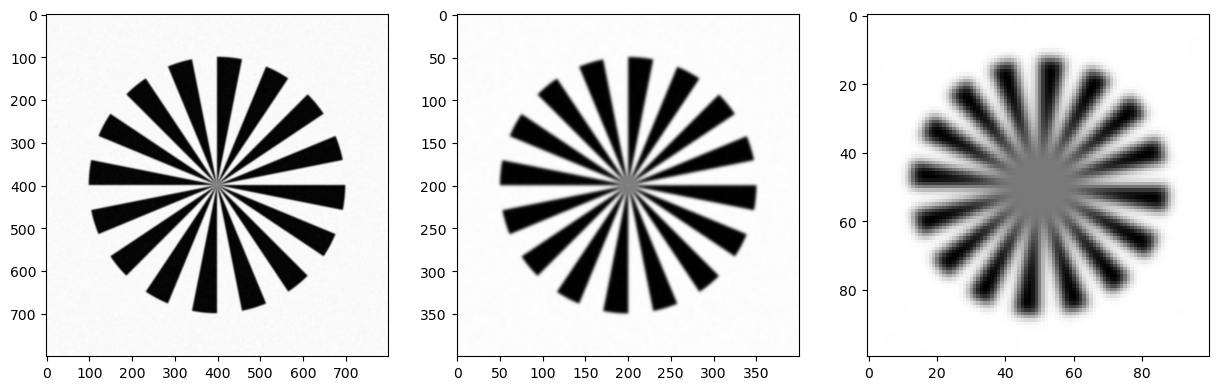

In [6]:
# 원본, 점점 줄어듦.
# 줄어들 때 앨리어싱 효과를 방지하기 위해 gaussian blur를 해줌

fig, axes = plt.subplots(1, 3, figsize=(15,8))
ax = axes[0]
ax.imshow(tti(pyr[0][0,0,0]), 'gray')
ax = axes[1]
ax.imshow(tti(pyr[1][0,0,0]), 'gray')
ax = axes[2]
ax.imshow(tti(pyr[3][0,0,0]), 'gray')
current_level = pyr[1]

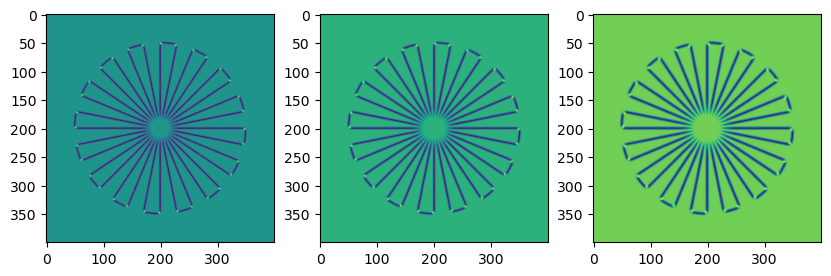

In [7]:
fig, axes = plt.subplots(1,3, figsize=(10,6))

# resp = KF.responses.CornerHarris(0.05)
# 미리 정의해둔 harris corner detection 사용해 각 cornerness를 측정
cornerness = resp(current_level[0])
for i in range(3):
    ax = axes[i]
    ax.imshow(tti(cornerness[0, i])) # visualize를 위한 PIL 이미지로 변경

Corner Detection을 어떤 Region에 대해서 할 수 있게

In [8]:
# Detector of the maximum of the local response: 
# ConvQuadInterp3d() : quadratic interpolation of the location
# ConvSoftArgmax3d() : softargmax estimation of the location

# Non-maximum suppresion
nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, h, w)
                                        stride=(1,1,1), # stride (s, h, w)
                                        padding=(1,1,1),
                                        temperature=0.1)

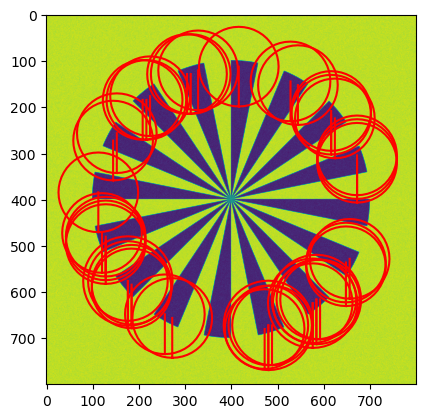

torch.Size([1, 40, 2, 3])


In [9]:
# Local Affine Region
def visualize_LAF(img, LAF, img_idx=0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

# Detect Harris Local
n_feats = 40
mr_size = 6.0

harris_local_detector = KF.ScaleSpaceDetector(n_feats, # 몇 개의 point를 detect
                                              resp_module=resp, # corner를 찾을 알고리즘
                                              nms_module=nms1, # nms 알고리즘
                                              mr_size=mr_size)

lafs, resps = harris_local_detector(timg)

visualize_LAF(timg, lafs)
print(lafs.shape)

### Duplication 제거

- nms의 threshold를 키운다고 해서 중복이 크게 줄어들지 않았음

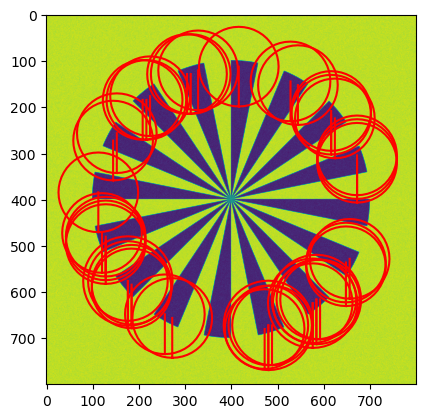

torch.Size([1, 40, 2, 3])


In [10]:
#n_feats = 40
mr_size = 6.0 
nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3),
                                       stride=(1,1,1),
                                       padding=(1, 1, 1),
                                       temperature=0.1,
                                       strict_maxima_bonus=100.) # nms window size를 조절

harris_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms1,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)
visualize_LAF(timg, lafs)
print(lafs.shape)

- Quadrative Interpolation 3D를 통해 subpixel 수준에서의 non-maximal suppression을 한 번 더 수행

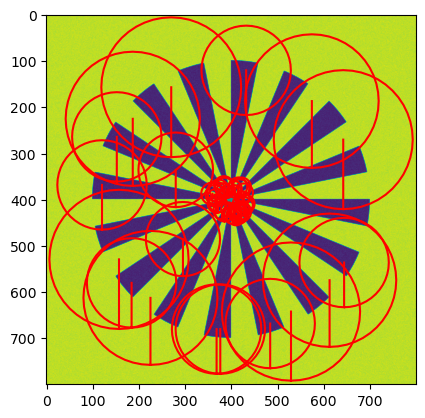

In [11]:
# W/O duplicates
n_feats = 50
mr_size = 6.0
nms = kornia.geometry.ConvQuadInterp3d(10, 2e-4)
harris_local_detector = KF.ScaleSpaceDetector(n_feats,
                                              resp_module=resp,
                                              nms_module=nms,
                                              mr_size=mr_size)

lafs, resps = harris_local_detector(timg)
visualize_LAF(timg, lafs)

## Harris가 아닌 다른 affine 모듈

- DoG, LoG
- scale-space detector에 shape estimator를 넣어서 실행

C:\Users\jjoro\AppData\Local\Temp\ipykernel_11052\2124665255.py:8: DeprecationWarning: `LAFAffineShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),


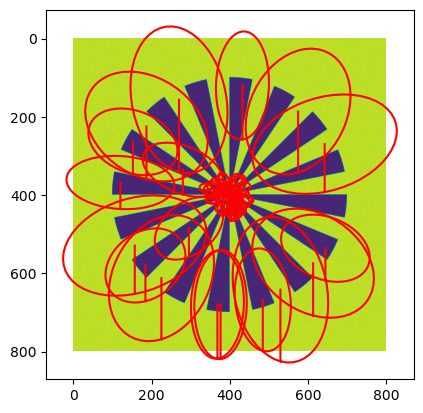

In [16]:
# Harris Affine features
harris_affine_local_detector = KF.ScaleSpaceDetector(n_feats,
                                                     # cornerharris
                                                     resp_module=kornia.feature.CornerHarris(0.05),
                                                     nms_module=nms,
                                                     mr_size=mr_size,
                                                     # affine 모듈을 별도로 넣어줌
                                                     aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                                     minima_are_also_good=False)
lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg, lafs)

- Feature Orientation Estimator 추가
    - 방향성 정보 visualize

C:\Users\jjoro\AppData\Local\Temp\ipykernel_11052\2048873986.py:6: DeprecationWarning: `LAFAffineShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),


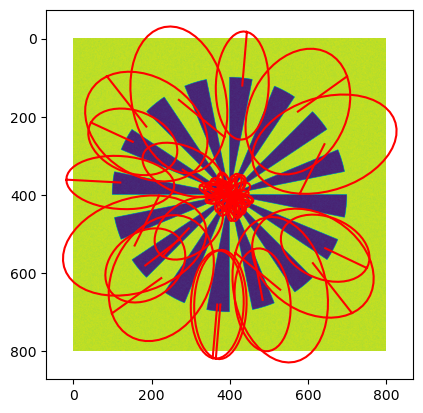

In [13]:
# Detect Feature Orientation
harris_affine_local_detector = KF.ScaleSpaceDetector(n_feats,
                                                     resp_module=kornia.feature.CornerHarris(0.05),
                                                     nms_module=nms,
                                                     mr_size=mr_size,
                                                     aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                                     ori_module=kornia.feature.LAFOrienter(patch_size=19))

lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg, lafs)

## Obtain patch descriptor using the obtained affine regions

- Kornia는 PyTorch 기반 학습이기 때문에 Tensor로 return

In [14]:
# Describe patches with SIFT descriptor
descriptor = KF.SIFTDescriptor(32)

patches = kornia.feature.extract_patches_from_pyramid(timg, lafs)
B, N, CH, H, W = patches.size()

# Descriptor는 [B, CH, H, W]를 사용하기 때문에 reshape
descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1) # SIFT descriptor를 얻는 알고리즘
print(descs.shape)
print(descs[0, 0])

torch.Size([1, 50, 128])
tensor([1.6467e-01, 1.9676e-01, 1.0487e-01, 3.9673e-02, 1.9676e-01, 1.9676e-01,
        6.1315e-02, 1.2636e-01, 6.4704e-02, 1.8127e-01, 5.1175e-02, 2.7647e-02,
        7.4260e-03, 9.2415e-03, 1.0706e-02, 5.1793e-03, 1.5070e-01, 2.4354e-02,
        2.3472e-04, 4.0687e-03, 1.7402e-01, 1.4604e-03, 5.3145e-02, 1.1710e-01,
        7.5814e-02, 1.6685e-01, 7.8568e-02, 9.7672e-02, 8.7283e-03, 1.4324e-02,
        8.5558e-03, 1.2027e-02, 3.2671e-02, 4.1927e-03, 5.1082e-02, 1.1412e-01,
        4.5142e-03, 4.7493e-03, 5.6021e-02, 8.4183e-02, 8.5145e-02, 1.9458e-01,
        1.2003e-01, 7.3694e-02, 2.5838e-02, 3.5144e-02, 7.0185e-03, 1.0035e-02,
        1.5283e-02, 1.4186e-01, 1.5485e-01, 1.9676e-01, 4.1246e-03, 6.0678e-02,
        1.9676e-01, 8.7895e-02, 6.3900e-02, 4.5764e-02, 1.1247e-01, 8.3514e-03,
        1.1894e-02, 9.6841e-03, 7.9914e-03, 7.2565e-03, 1.5916e-01, 1.9574e-01,
        1.0767e-01, 1.2060e-02, 1.8534e-01, 1.6888e-01, 1.9665e-01, 5.1151e-03,
        1.7824e